# <center> <font style="color:rgb(100,109,254)">Custom ASL Classification using your hands</font> </center>

We have seen a complete pipeline of HOG + SVM for a complex dataset, which contained about 29 classes. Now we want to make it work with our webcam, so how about a real time classifier that can classify on your webcam feed using your hand gestures. So for that we could take the model we created but that wouldn't be of much use since the data variations between the training and inference environment is a lot different, i.e. you will have a different background, hand shape and so on. So now we need to train another classifier on your hands.

In [26]:
# Importing the Required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn import svm
from random import shuffle
from tqdm import tqdm_notebook as tqdm

**Resize the ASL Image for later usage.**

In [27]:
cam = cv2.VideoCapture(1,cv2.CAP_DSHOW) 
cam_width =  cam.get(3)
cam_height = cam.get(4)

asl_img = cv2.imread('Media/M4/asl22.png')
asl_img = cv2.resize(asl_img, (int(cam_width), int(cam_height)))
cam.release()

## <font style="color:rgb(134,19,348)">  Generate Custom Data </font>
The script below allows you to collect data via your webcam.

In [28]:
# Path for our training data, you can change this to `custom_testing` for storing test data.
training_path = 'Media/M4/custom_training'

In [30]:
# Initialize the Webcam
cam = cv2.VideoCapture(1, cv2.CAP_DSHOW) 

# Create a named window
cv2.namedWindow("Train the Samples")

# Create a Counter
img_counter = 0

# Define all the Classes you want to classify with a space.
classes_string = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'

# Now we will store each class seperately
classes = classes_string.split(' ')

# We are storing the ASCII values of all the letters in a new list. 
asci_values = [ord(item) for item in classes]

# These are all the special characters, Note: nothing asci value 9 is from the tab button.
special_case = [('space', 32), ('del', 0), ('nothing', 9)]

# Append the special values with their asci values.
for char, asci in special_case:
    asci_values.append(asci)
    classes.append(char)

#Initializing storage
storage = None

# Variable deciding whether to override previous saved samples
override = False

while True:
    
    ret, frame = cam.read()  
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
    
    # Taking ascii value of input key from user
    k = cv2.waitKey(1)
    
    # Check to make sure if the key that user pressed is among our classes
    if k in asci_values:
        
        # Now get the index of that class/letter from the ascii list.
        class_pos = asci_values.index(k)
        
        # Using the index get the associated class name/letter from the classes list.
        class_name = classes[class_pos].upper()
        
        # Extract the part of the frame where the hand is present
        image = frame[1:230,380:620]
        
        class_path = os.path.join(training_path, class_name)

        if not os.path.exists(class_path):
            os.mkdir(class_path)  
            
        # Reset the counter if you're now storing the samples of a different class.
        if storage != k:
            img_counter = 0
            
        # Adding samples vs Overriding them.
        if not override and img_counter == 0:
          if os.listdir(class_path):
            img_counter = max([int(img_name.replace(class_name,'').replace('.jpg','')) for img_name in os.listdir(class_path)])
            
        # Using the varibales above set up the image name.
        img_name = "{}{}.jpg".format(class_name, img_counter)

        # Save the image in folder named custom_training/<NAME_OF_CLASS>/  
        cv2.imwrite(os.path.join(training_path, '{}/{}'.format(class_name, img_name)), image)
        
        # Show the class name and the number of stored samples of the class
        cv2.putText(frame, "Class: {} , Sample Count: {}".format(class_name, img_counter), (10, 35),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        
        
        # Remember the class we're taking samples of.
        storage = k
        
        # Increment the counter for every new sample
        img_counter += 1
    
    # Exit if Esc is pressed.
    elif k == 27: 
        break
    
    # Draw a rectangle to show where to make the hand gestures.
    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    
    stacked = np.hstack((frame,asl_img))
    
    # Show the image
    cv2.imshow("Train the Samples", stacked)
    
cam.release()
cv2.destroyAllWindows()    

## <font style="color:rgb(134,19,348)"> Load the Training Classes </font>


In [31]:
# The names of our image classes are the names of sub folders.
train_classes = [directory for directory in os.listdir(training_path) if os.path.isdir(os.path.join(training_path,directory))]

In [32]:
# Check out the labels in the training set.
print(train_classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NOTHING', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## <font style="color:rgb(134,19,348)"> Display a single Image from Each Class and the total number of classes </font>


Number of Samples in Class A: 54
Number of Samples in Class B: 75
Number of Samples in Class C: 62
Number of Samples in Class D: 52
Number of Samples in Class E: 57
Number of Samples in Class F: 56
Number of Samples in Class G: 65
Number of Samples in Class H: 68
Number of Samples in Class I: 54
Number of Samples in Class J: 59
Number of Samples in Class K: 63
Number of Samples in Class L: 57
Number of Samples in Class M: 52
Number of Samples in Class N: 63
Number of Samples in Class NOTHING: 54
Number of Samples in Class O: 71
Number of Samples in Class P: 61
Number of Samples in Class Q: 58
Number of Samples in Class R: 57
Number of Samples in Class S: 88
Number of Samples in Class SPACE: 53
Number of Samples in Class T: 85
Number of Samples in Class U: 60
Number of Samples in Class V: 52
Number of Samples in Class W: 64
Number of Samples in Class X: 61
Number of Samples in Class Y: 57
Number of Samples in Class Z: 55


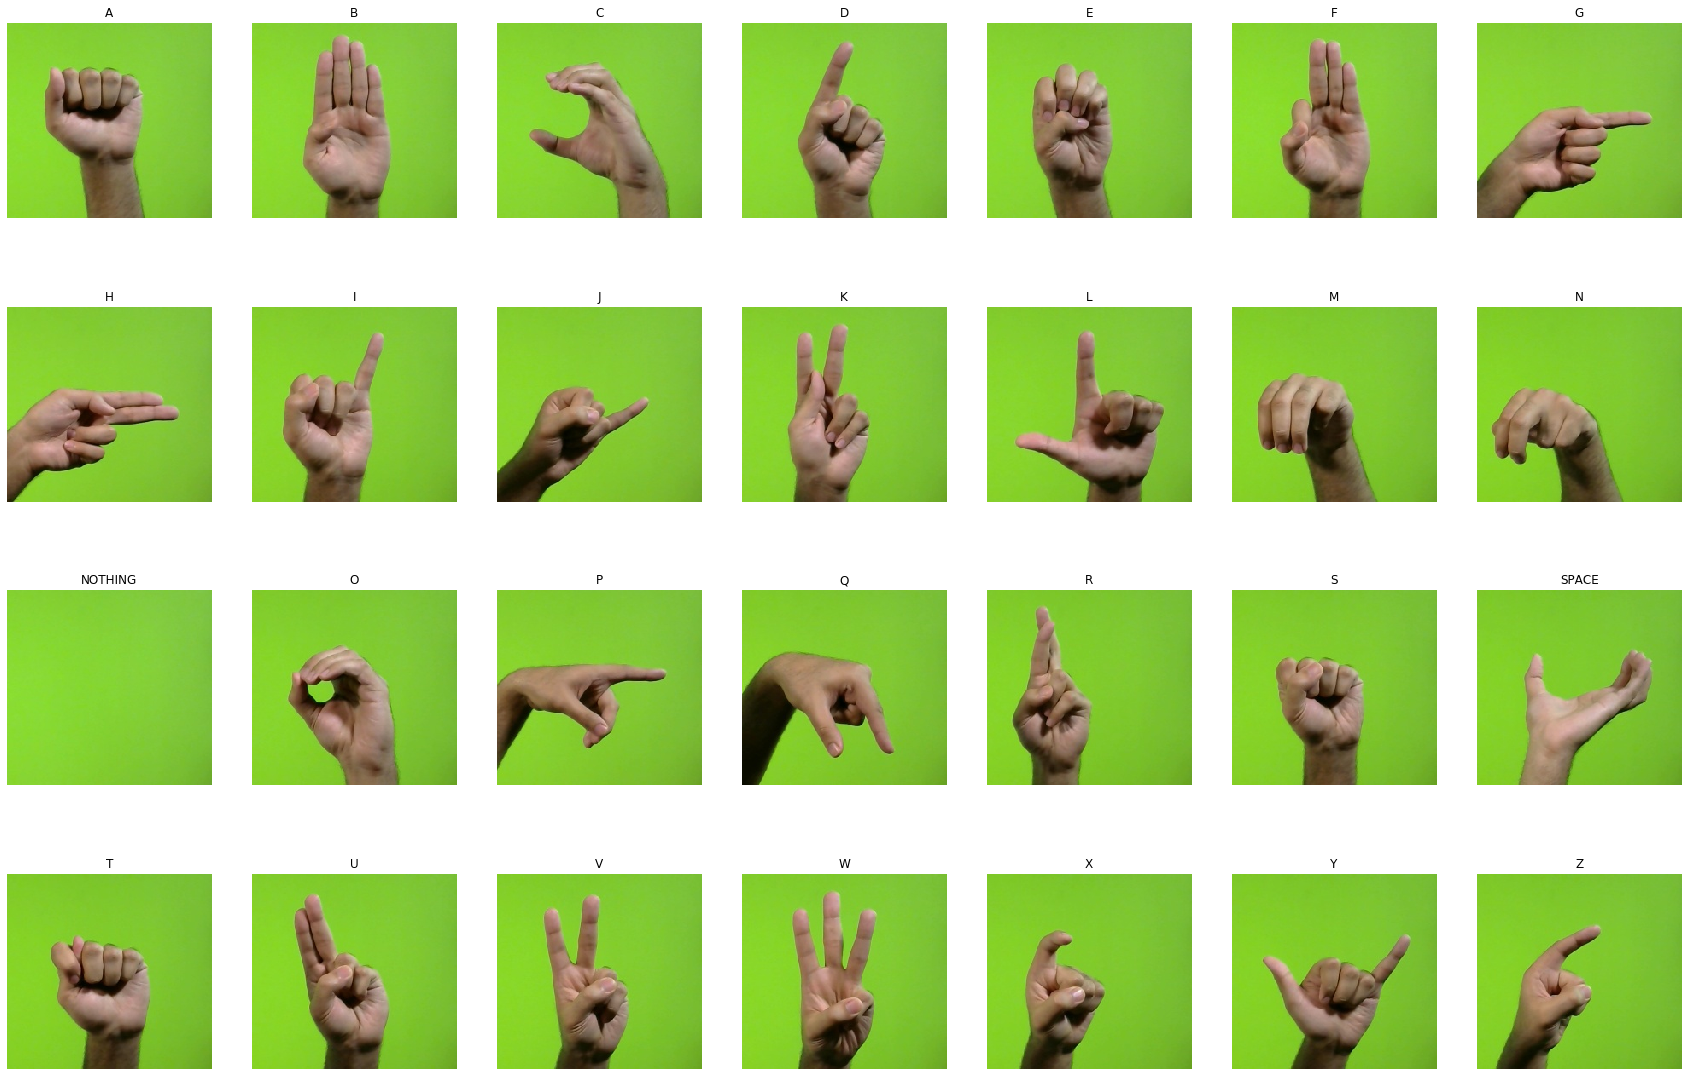

In [33]:
# Determine size, cols and rows for display
plt.figure(figsize=[30,20])
cols = 7
rows = int(np.ceil(len(train_classes)/cols))
Single_images_of_each_class = []

# Loop for each class
for i in range(len(train_classes)):
    
        # Take 1 image from each class
        name = os.listdir( os.path.join(training_path,train_classes[i]))[2]        
        print('Number of Samples in Class {}: {}'.format(train_classes[i], 
                                                         len(os.listdir( os.path.join(training_path,train_classes[i] )))))

        # Read and display image
        image = cv2.imread(os.path.join(training_path,train_classes[i],name))
        
        # Saving one image from each class for later use.
        Single_images_of_each_class.append((train_classes[i], image))
        
        plt.subplot(rows,cols,i+1);plt.imshow(image[:,:,::-1]);plt.title(train_classes[i]);plt.axis('off');

## <font style="color:rgb(134,19,348)">Combine All Single images of Each Class  </font>

Below we are combining all single images from each class to create one single image, this image will help us in the prediction step. I'm using a 7 column image but you can change that.

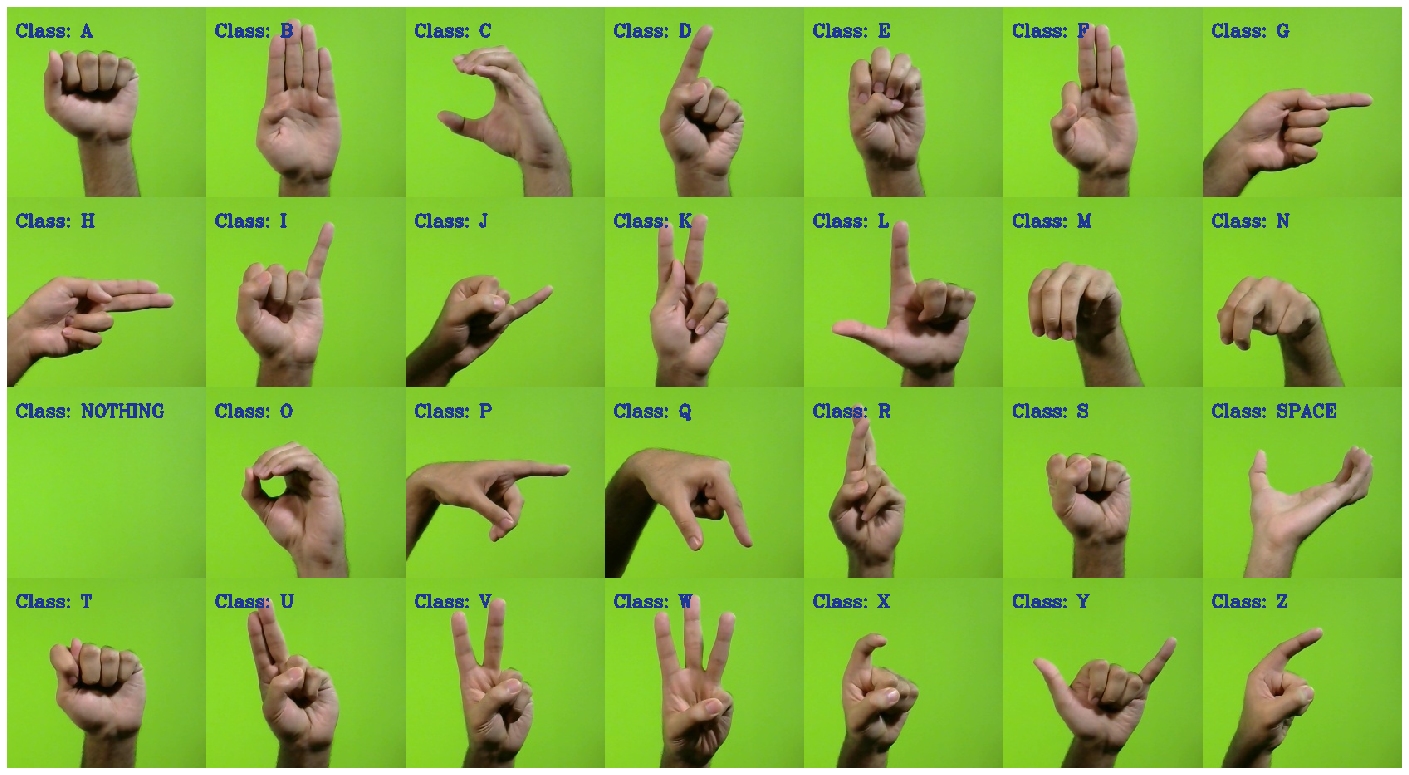

In [34]:
counter = 0

# Horizontal Stacking
stack = None

# Vertical Stacking
full_stack = None

# Number of Columns to use.
columns = 7

for class_name, img in Single_images_of_each_class:    
    
    # Put the class name on the image.
    cv2.putText(img, "Class: {}".format(class_name), (10, 35), cv2.FONT_HERSHEY_COMPLEX, 0.7, (150, 55, 30), 2)
    
    if stack is None:
        stack = img
    else:
        stack = np.hstack((stack,img))

    counter +=1
    
    if counter == columns:
        
          counter = 0
            
          if full_stack is None:
                full_stack = stack.copy()

          else:
                full_stack = np.vstack((full_stack, stack))                
          stack = None    
            
if columns - counter > 0 and counter !=  0:
    width = (columns - counter)  * img.shape[1]
    height = img.shape[0]
    fill_img = np.full((height, width, 3), 255, dtype='uint8')
    stackc = np.hstack((stack, fill_img))
    
    full_stack = np.vstack((full_stack, stackc))

plt.figure(figsize=[25,25])
plt.imshow(full_stack[:,:,::-1]);plt.axis('off');

# Finally resize this according to the dimensions of your camera.
full_stack = cv2.resize( full_stack, (int(cam_width), int(cam_height)))

## <font style="color:rgb(134,19,348)">Create a Training & Testing Split  </font>

Here we will split our original data into training and test 

In [35]:
# Define the percentage of data you want for the test set.
percentage = 10

for i in range(len(train_classes)):
    
    # Get the number of samples for each class
    length = len(os.listdir( os.path.join(training_path, train_classes[i] )))
    
    # Create a splitting point based on the percentage the user defined.
    splitter = round((length * percentage) / 100)
    
    # Print out the Training and Testing sample count of each class
    print('Total Samples in {}: {}, Train:{}, Test{}'.format(train_classes[i], length, (length-splitter), splitter))

# Create two dictionaries that will hold the training and test data
test_image_names  = {}
train_image_names = {}

# Now we will randomely shuffle our data and split between training and test data.
for i in range(len(train_classes)):
    
    # Get all the image names
    all_img_names = os.listdir(os.path.join(training_path, train_classes[i]))
    
    # Shuffle all the names
    shuffle(all_img_names)
    
    # Split the data
    train_image_names[train_classes[i]] =  all_img_names[splitter:]
    test_image_names[train_classes[i]]  =  all_img_names[:splitter]

Total Samples in A: 54, Train:49, Test5
Total Samples in B: 75, Train:67, Test8
Total Samples in C: 62, Train:56, Test6
Total Samples in D: 52, Train:47, Test5
Total Samples in E: 57, Train:51, Test6
Total Samples in F: 56, Train:50, Test6
Total Samples in G: 65, Train:59, Test6
Total Samples in H: 68, Train:61, Test7
Total Samples in I: 54, Train:49, Test5
Total Samples in J: 59, Train:53, Test6
Total Samples in K: 63, Train:57, Test6
Total Samples in L: 57, Train:51, Test6
Total Samples in M: 52, Train:47, Test5
Total Samples in N: 63, Train:57, Test6
Total Samples in NOTHING: 54, Train:49, Test5
Total Samples in O: 71, Train:64, Test7
Total Samples in P: 61, Train:55, Test6
Total Samples in Q: 58, Train:52, Test6
Total Samples in R: 57, Train:51, Test6
Total Samples in S: 88, Train:79, Test9
Total Samples in SPACE: 53, Train:48, Test5
Total Samples in T: 85, Train:77, Test8
Total Samples in U: 60, Train:54, Test6
Total Samples in V: 52, Train:47, Test5
Total Samples in W: 64, Train:

In [36]:
test_image_names.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NOTHING', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

## <font style="color:rgb(134,19,348)">  Initialize Hog Descriptor</font>


You can use `cv2.HOGDescriptor()`to initialize the hog descriptor. 

In [37]:
# Initialize hog parameters, I'm initializing with all the default values.
winSize = (120, 120) 
blockSize = (40, 40)
blockStride = (20, 20)
cellSize = (20, 20)
nbins = 9
derivAperture = 1 # has no effect 
winSigma = -1 # going to be equal to 4
histogramNormType = 1 # has no effect 
L2HysThreshold = 0.2
gammaCorrection = False
nlevels = 64 
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, 
                        L2HysThreshold, gammaCorrection, nlevels, signedGradient)

## <font style="color:rgb(134,19,348)">  Compute and Store Hog Feature Vectors of images</font>

Now we will loop through each image and store its feature vector and label. Label of any image is the name of the class it belongs. 

**Start Feature & Label Extraction**

In [38]:
def getfeaturevectors(dictionary):
    # This list will hold the final feature vectors.
    Hog_feature_vectors = []

    # This list will hold the labels for each image.
    labels = []
    
    # This loop loops for each class (in total we have 29 classes for this dataset), we're also using tqdm for a progress bar.
    for classe_name in tqdm(list(dictionary.keys())):

            # This loop loops for each sample in each class (each class have approximately)
            for img_name in dictionary[classe_name]:

                # Read the image
                image = cv2.imread(os.path.join(training_path, classe_name, img_name))

                # Resize the image, if the image is corrupted then leave it 
                try:
                    image = cv2.resize(image, (120, 120))
                    
                except:
                    #print('Error Readimg image {}'.format(os.path.join(path,classes[i], j)))
                    continue

                # Compute the descriptor            
                descriptor = hog.compute(image)

                # Store the feature vector and the label
                Hog_feature_vectors.append(descriptor.reshape(-1))

                # Also store the label for each class
                labels.append(classe_name)

    print('Total Descriptors: {} and Total Labels: {}'.format(len(Hog_feature_vectors), len(labels) ))
    
    # Return the feature vectors with their labels.
    return Hog_feature_vectors, labels

**Lets use our function to get features and labels for the training data**

In [39]:
hog_feature_vectors, labels = getfeaturevectors(train_image_names)


Total Descriptors: 1535 and Total Labels: 1535


## <font style="color:rgb(134,19,348)"> Initialize the SVM Classifier </font>


```Python
model = svm.SVC()
```
- **`C:`** a float value, optional (default=1.0)
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- **`kernel:`** a string, optional (default=`rbf`)
Specifies the kernel type to be used in the algorithm. It must be one of `linear`, `poly`, `rbf`,  or `sigmoid`. If none is given, `rbf` will be used. 

- **`degree:`** an int, optional (default=3)
Degree of the polynomial kernel function (`poly`). Ignored by all other kernels.

- **`gamma:`** string, optional (default=`scale`)
Possible values are `scale` and `auto` Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. if gamma=`scale`(default) is passed then it uses `1 / (n_features * X.var())` as value of gamma, and if `auto`, it uses `1 / n_features`

You can look at other parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [40]:
# Initializing SVM Model with rbf kernel 
model = svm.SVC(kernel='rbf', C = 30.0, gamma='scale')

##  <font style="color:rgb(134,19,348)"> Start Training the Model </font>

You can start training with svm by calling the `model.fit()` method.

In [41]:
%%time
model.fit(hog_feature_vectors, labels)
print("Training Completed")

Training Completed
Wall time: 1.16 s


## <font style="color:rgb(134,19,348)">Setting up the Test data for Evaluation  </font>

Now by passing in testing dictionary we can get hog feature vectors and labels for the test data.

In [42]:
hog_feature_test_vectors, test_labels = getfeaturevectors(test_image_names)


Total Descriptors: 166 and Total Labels: 166


## <font style="color:rgb(134,19,348)">  Evaluating performance on Test Data </font>

Now you can evaluate this data by using the function **`model.score()`**

In [43]:
score = model.score(hog_feature_test_vectors, test_labels)
print('Accuracy of Model is {:.2f}%'.format(score*100))

Accuracy of Model is 100.00%


##  <font style="color:rgb(134,19,348)"> You can Save and Load Models for later use </font>

First import the pickle library and then use `pickle.dump()` function. So pickle library allows you to serialize your machine learning model and save the serialized format to a file.

In [44]:
pickle.dump(model, open('Media/M4/svm_asl_custom.sav', 'wb'))

**Later on a different notebook you can load back the model by using `pickle.load()`, here `wb` and `rb` are write binary and read binary operations**

In [45]:
# load the model from disk
loaded_model = pickle.load(open('Media/M4/svm_asl_custom.sav', 'rb'))

## <font style="color:rgb(134,19,348)">Predict on Live Webcam Feed in Real Time  </font>

Now once you're satisfied with the performance of your model then its ready to predict on new images using `model.predict()`.

In [46]:
# Read from camera
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW);

while (True):
    ret ,frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)

    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    image = frame[1:230,380:620]
    
    # Resize the image as required.
    image = cv2.resize(image, (120, 120))
    
    # Compute the descriptor            
    descriptor = hog.compute(image)
    
    # Extract the label
    label = loaded_model.predict(descriptor.reshape(1,-1))[0]    
    
    # Put the label and show the results
    cv2.putText(frame, 'Prediction: {}'.format(label), (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0,(100, 55, 200), 3)  
    
    stacked = np.hstack((frame, full_stack))
    cv2.imshow("Results", stacked)
    
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

###  <font style="color:rgb(34,169,134)">Assignment: Make an ASL Based Text Editor</font>
Your task would be to make a Vision based text writer, that would write full sentences with characters of ASL that you make with your hands. You can get some ideas from here: 

**Note:** The code for the hand gesture based calculator is a little messy, but it can give you an idea of where to start.

**Hint:** Instead of taking the first image from each class, you should smooth the results like take the mode of every 15 predictions to get the dominant class name.